In [4]:
import numpy as np
import quantities as pq
import neo
import elephant
import viziphant
from scipy.signal import correlate
np.random.seed(4542)

In [5]:
def generate_synthetic_data(params):
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)

    M,N,D,T,nrn_fr,pg_fr,background_noise_fr,seed = params['M'], params['N'], params['D'], params['T'], params['nrn_fr'],params['pg_fr'],params['background_noise_fr'],params['seed']    
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)
    np.random.seed(seed)

    K_dense = np.random.rand(N,D,M)*1000
    nrn_frs = np.zeros((M))
    for m in range(M):
        nrn_frs[m] = np.random.poisson(nrn_fr)
        K_dense[:,:,m] = (K_dense[:,:,m] < nrn_frs[m]).astype('int')
    K_sparse = np.where(K_dense)
    K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)


    # dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
    # spare B: set of all times t and pg's b
    B_dense = np.random.rand(M,T)*1000
    pg_frs = np.zeros((M))
    for m in range(M):
        pg_frs[m] = np.random.poisson(pg_fr)
        B_dense[m,:] = (B_dense[m,:] < pg_frs[m]).astype('int')
    B_sparse = np.where(B_dense)
    B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

    # now to make the full raster plot keeping the labels in-tact
    # dense A: the layered binary images of all neuron spikes by PG ( N x T x M
    A_dense = np.zeros((N,T+D,M+1))
    A_dense[...,0] = np.random.rand(N,T+D)*1000
    A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
    for i in range(len(B_sparse[0])):
        t = B_sparse[1][i]
        b = B_sparse[0][i]
        A_dense[:, t:t+D, b] += K_dense[...,b-1]

    A_sparse = np.where(A_dense)
    A_dense = np.sum(A_dense,axis=2)
    A_dense[A_dense>1] = 1
    
    return A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse



In [6]:
def fix_spade(patterns, win_size):
    spade_patterns = []
    for pattern in patterns:
        spade_patterns.append(np.array([np.sort(np.array(pattern['itemset'])) % D, np.sort(np.array(pattern['neurons']))]).T)
    return spade_patterns
        

In [7]:
def get_acc(matrix_x,matrix_y):
    # Calculate cross-correlation matrix
    cross_corr_matrix = np.zeros((matrix_x.shape[2], matrix_y.shape[2]))

    for x_channel_idx in range(matrix_x.shape[2]):
        for y_channel_idx in range(matrix_y.shape[2]):
            cross_corr_matrix[x_channel_idx, y_channel_idx], _ = max_overlap(matrix_x[...,x_channel_idx],matrix_y[...,y_channel_idx])
#     print(cross_corr_matrix)
#     print( np.sum(matrix_x[...,x_channel_idx]))
    SM_acc_m1 = np.max(cross_corr_matrix,axis=1)
    return SM_acc_m1, cross_corr_matrix

In [8]:
def max_overlap(image, kernel):
    result = np.zeros((image.shape[1]+kernel.shape[1]-1))
    for n in range(image.shape[0]):
        result += correlate(image[n,:], kernel[n,:], mode = 'full')
    return np.max(result)/max(np.sum(image),np.sum(kernel)), np.argmax(result)

In [9]:
M = 1
N = 40
D = 51
T = 1000
nrn_fr = 10
pg_fr = 10
background_noise_fr = 15
seed=1

params = {
    'M':M,
    'N':N,
    'D':D,
    'T':T,
    'nrn_fr':nrn_fr,
    'pg_fr':pg_fr,
    'background_noise_fr':background_noise_fr,
    'seed':seed
}

In [10]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = generate_synthetic_data(params)

In [11]:
len(A_sparse[0])

769

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = np.array(sns.color_palette("tab10"))
palette = np.concatenate(([[0,0,0]],palette))

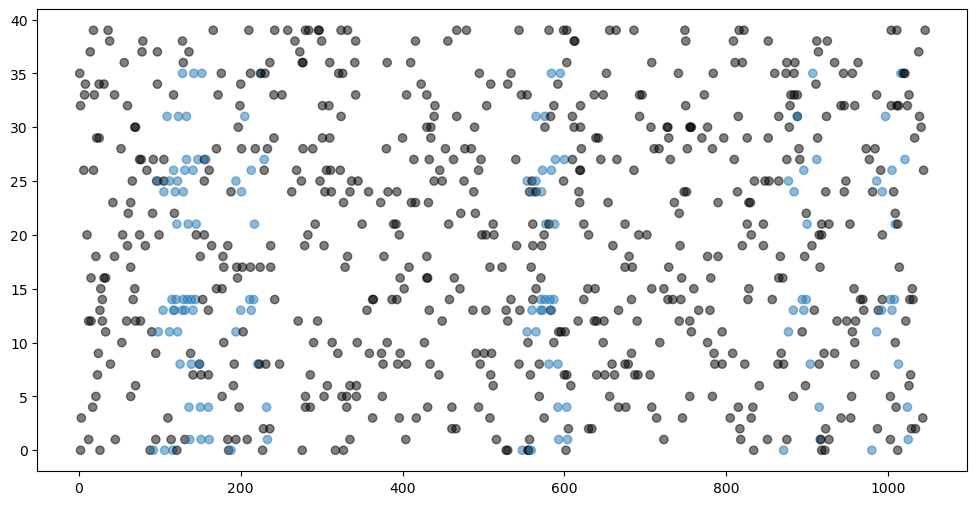

In [13]:
plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]],alpha=0.5)
# plt.scatter(A_sparse[1],A_sparse[0],c='black',alpha=0.7)
plt.show()

### I have to use the annoying spiketrain objects...

In [14]:
from neo.core import SpikeTrain

In [15]:
spike_trains = [SpikeTrain(A_sparse[1][A_sparse[0]==n] ,units= pq.ms, t_stop=T+D) for n in range(N)]

<Axes: xlabel='Time (ms)'>

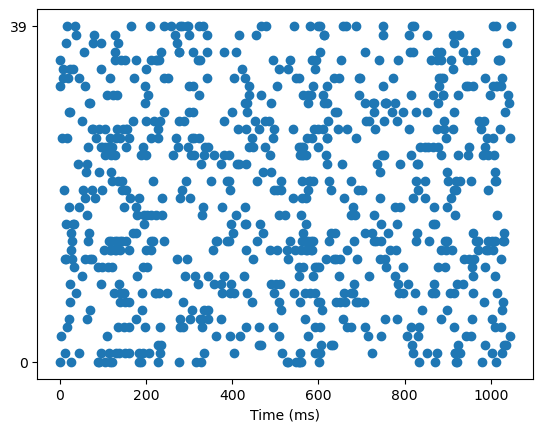

In [16]:
viziphant.rasterplot.rasterplot(spike_trains)

In [17]:
import time

In [18]:
tot_start = time.time()
output = elephant.spade.spade(spike_trains, bin_size=pq.ms, winlen=D,
    output_format='concepts',n_surr=100 ,alpha=0.05)
end = time.time()
print(end-tot_start)
start = time.time() 

patterns = output['patterns']
pvalue_spectrum = output['pvalue_spectrum']
non_sgnf_sgnt = output['non_sgnf_sgnt']

patterns = elephant.spade.pattern_set_reduction(patterns,non_sgnf_sgnt,D,pvalue_spectrum)
patterns = elephant.spade.concept_output_to_patterns(patterns, D, pq.ms)
tot_end = time.time()

print(tot_end - start)

print(tot_end - tot_start)

Time for data mining: 1.5968577861785889
Time for pvalue spectrum computation: 4.827718734741211
6.465704917907715
0.05143260955810547
6.51713752746582


In [21]:
len(output['patterns']), len(patterns)

(58, 5)

In [22]:
spade_patterns = fix_spade(patterns,D)
len(spade_patterns)

5

In [23]:
win_size = (K_dense.shape[0],1+max([max(k[:,0]) for k in spade_patterns]))
spade_imgs = np.zeros((*win_size,len(spade_patterns)))
for p, pattern in enumerate(spade_patterns):
    for (i,j) in pattern: 
        spade_imgs[j,i,p] = 1

In [24]:
spade_imgs.shape, K_dense.shape

((40, 51, 5), (40, 51, 1))

In [42]:
acc, test = get_acc(K_dense,spade_imgs)
acc

array([0.88888889])

In [26]:
spade_patterns[0].T

array([[ 2,  0, 47, 46, 46, 35,  8,  3, 14, 27, 25, 30, 31, 15,  8, 27,
        43, 19, 38],
       [ 0,  1,  1,  4,  7,  8, 11, 13, 13, 13, 14, 14, 21, 24, 25, 26,
        27, 31, 35]], dtype=int32)

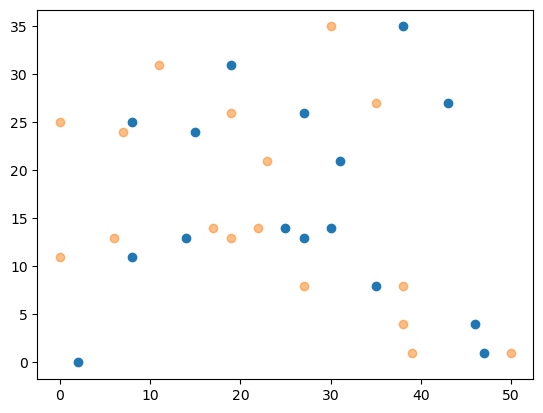

In [41]:
plt.figure()
i=2
plt.scatter(K_sparse[1],K_sparse[0])
plt.scatter(spade_patterns[i].T[0],spade_patterns[i].T[1],alpha=0.5)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

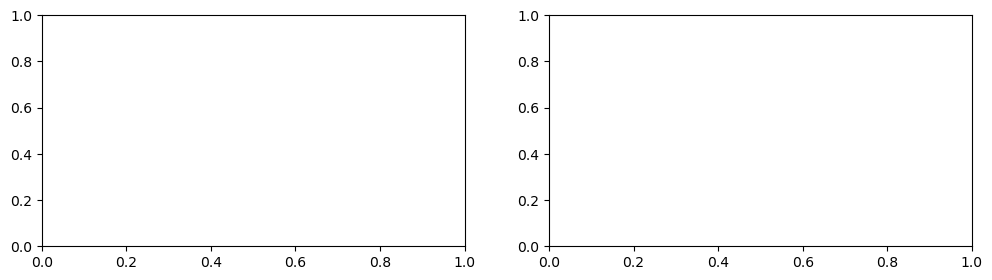

In [120]:
motif_map = (np.arange(0,M),np.argmax(test,axis=1))
motif_map
fig,ax = plt.subplots(len(motif_map[0]),len(motif_map),figsize=(12,M*3))
for i,(a,b) in enumerate(zip(motif_map[0],motif_map[1])):
    ax[i,0].scatter(np.where(K_dense[...,a])[1],np.where(K_dense[...,a])[0],c=palette[i+1])
    ax[i,1].scatter(np.where(spade_imgs[...,b])[1],np.where(spade_imgs[...,b])[0],c=palette[i+1])

ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Closest Matching detected Motif')
plt.show()

In [210]:
acc

array([0.66666667, 1.        , 1.        , 1.        , 1.        ,
       0.        , 1.        , 1.        ])

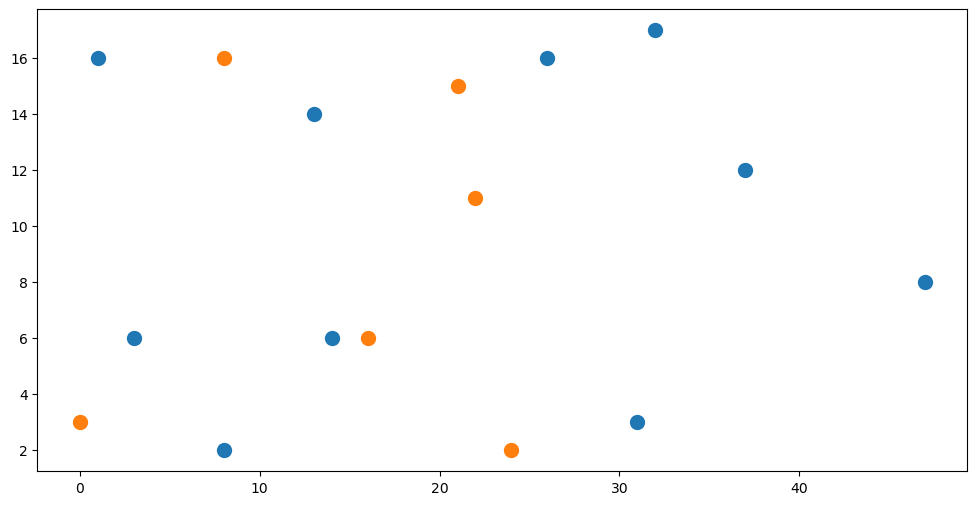

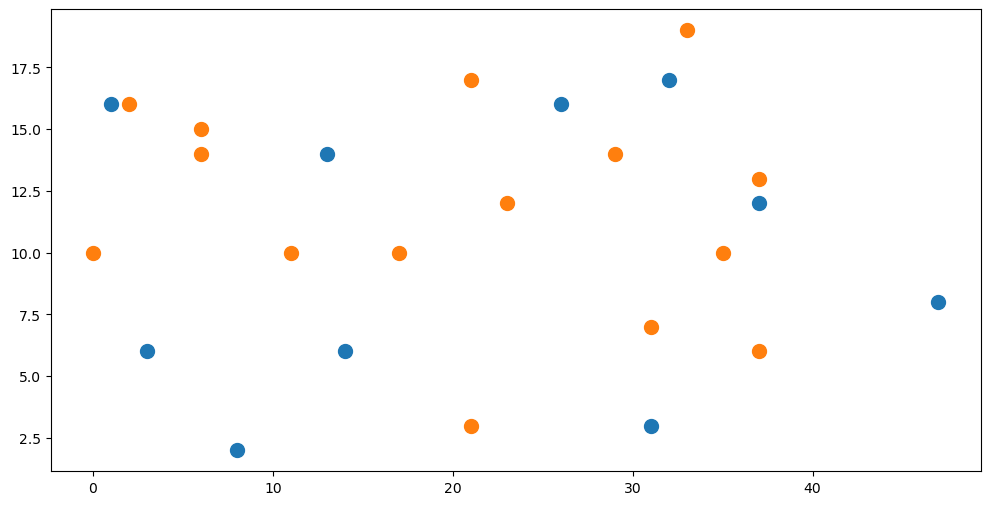

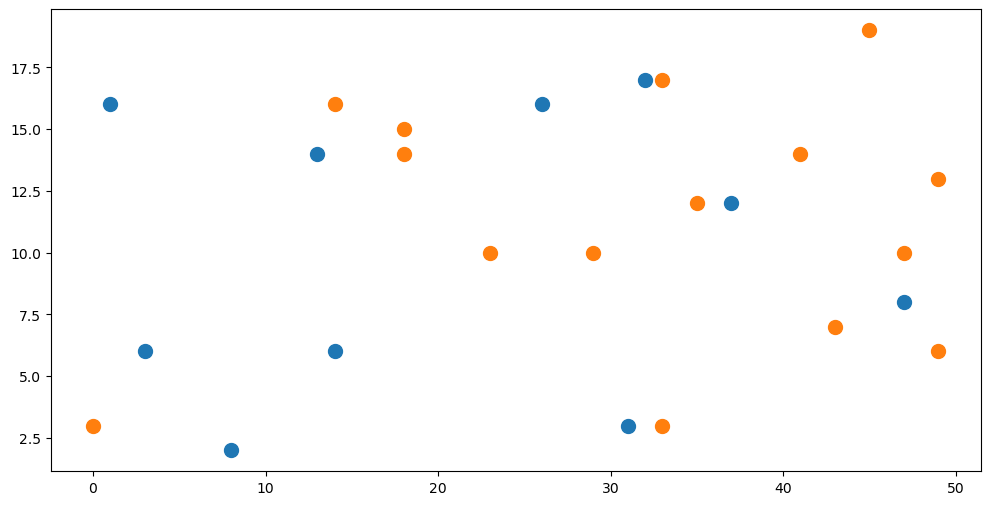

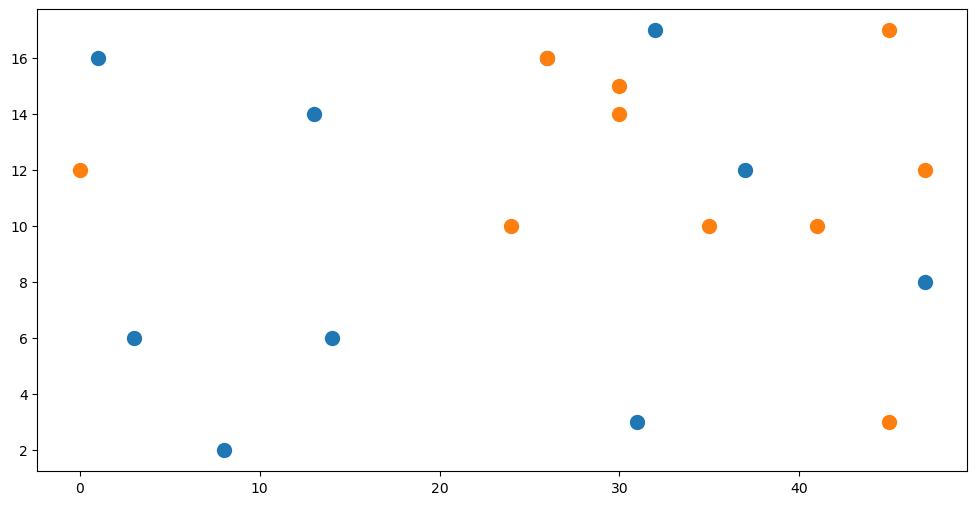

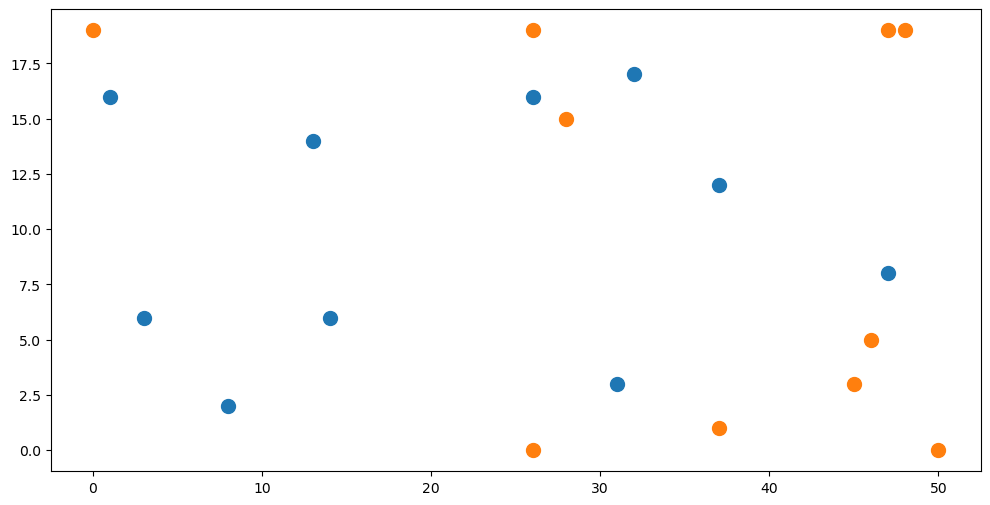

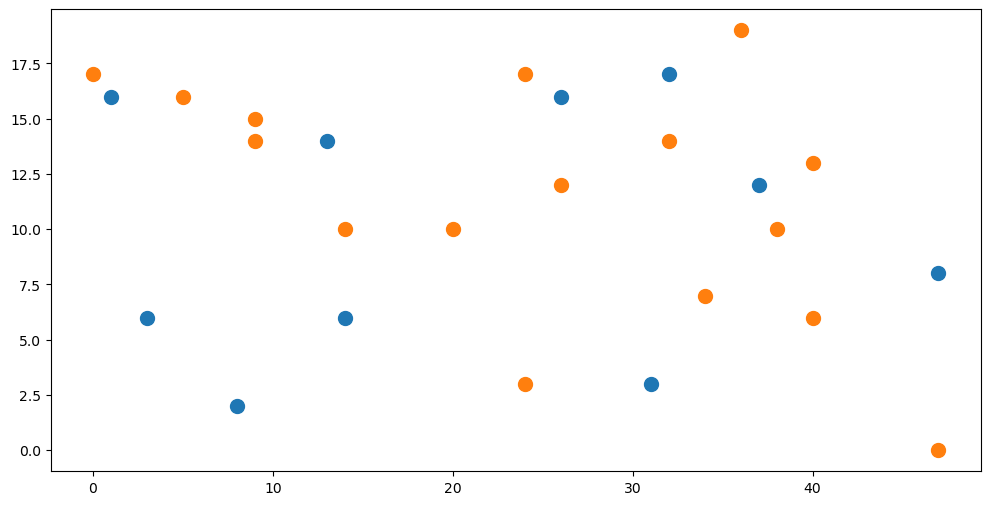

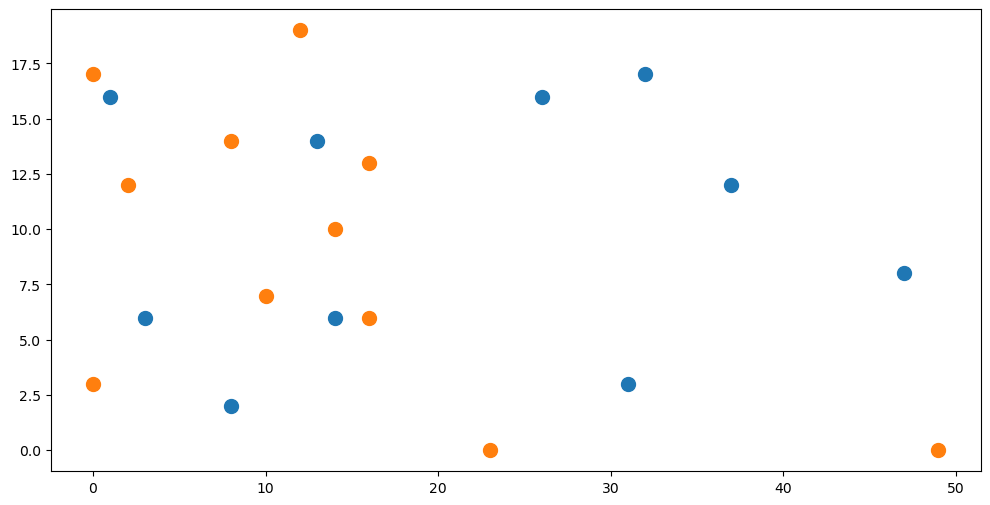

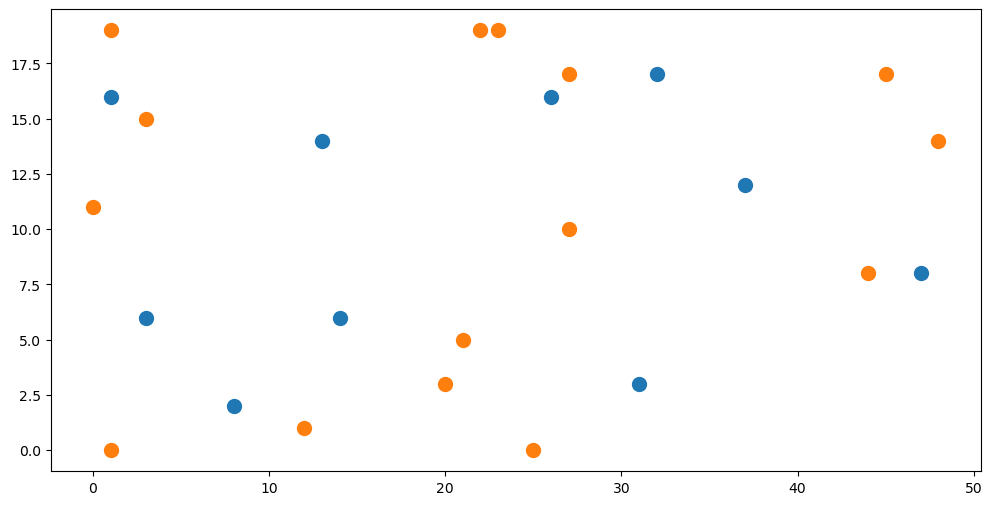

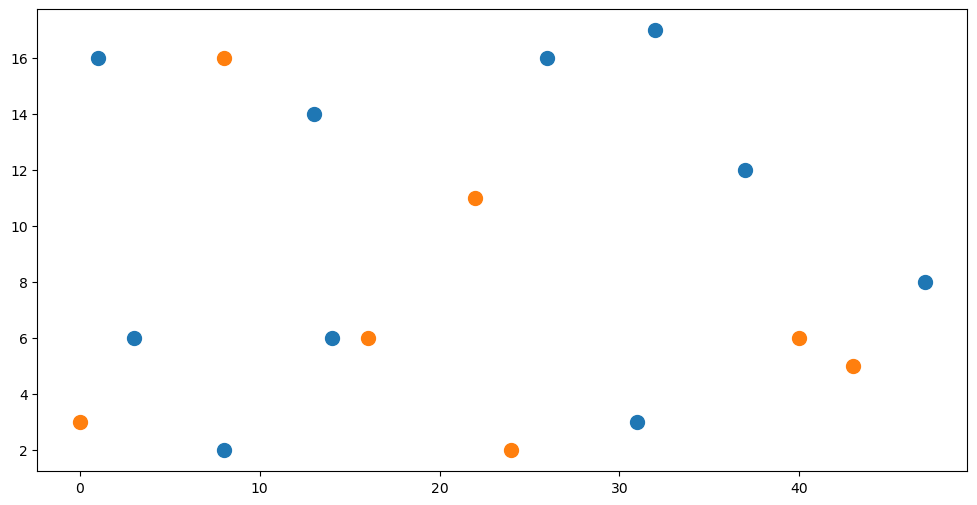

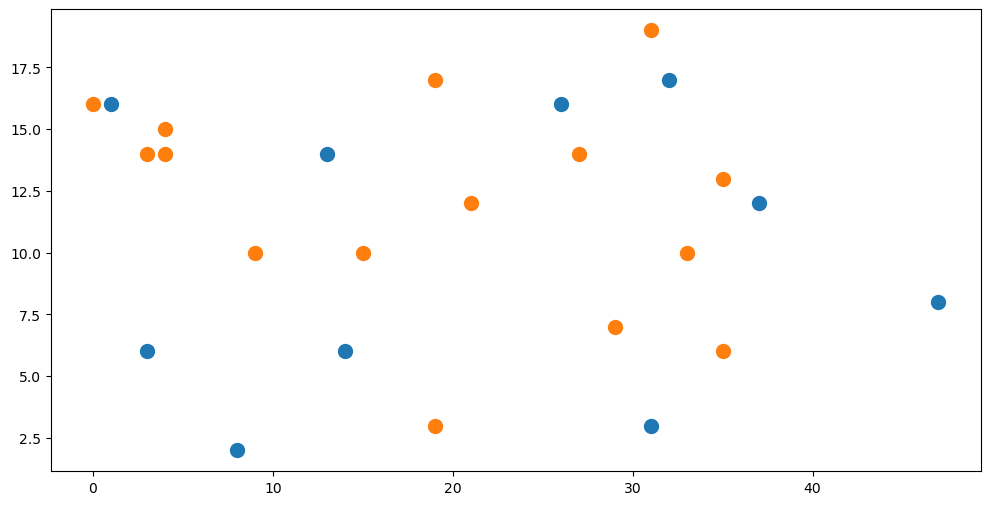

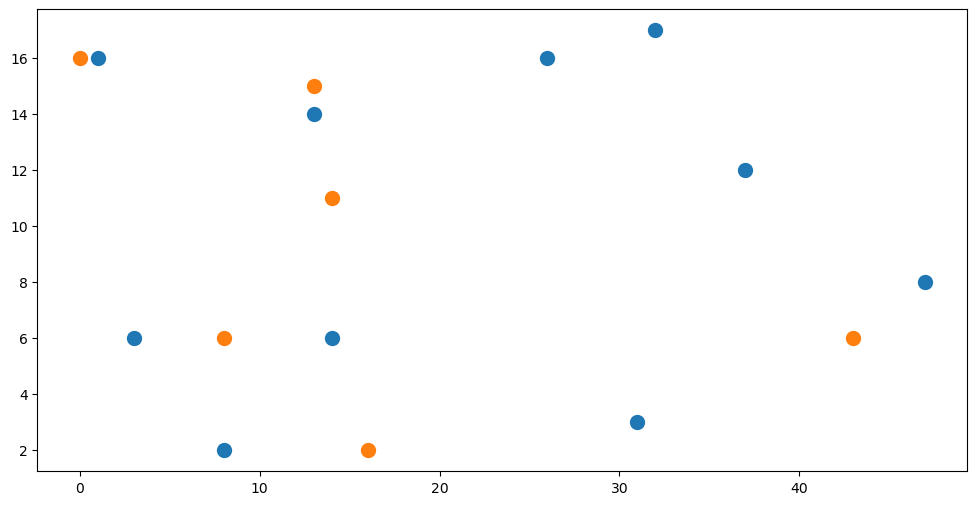

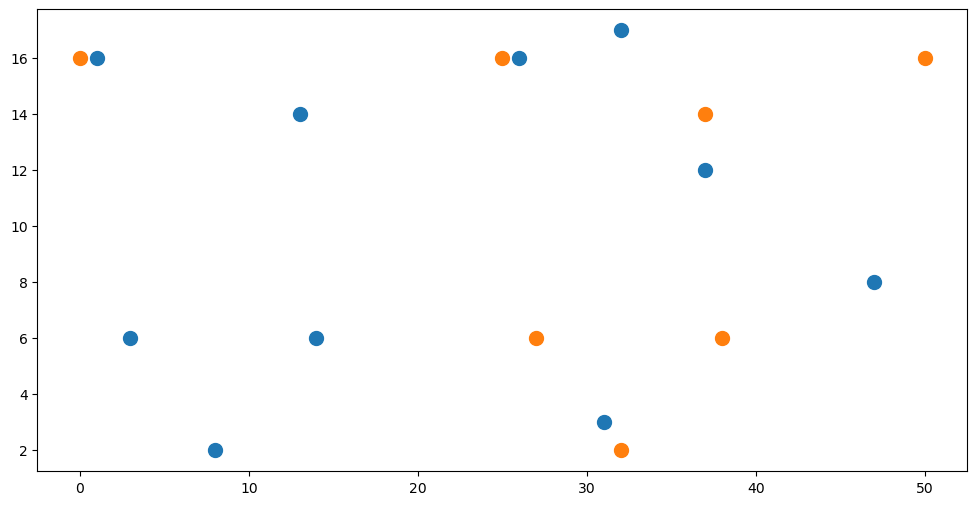

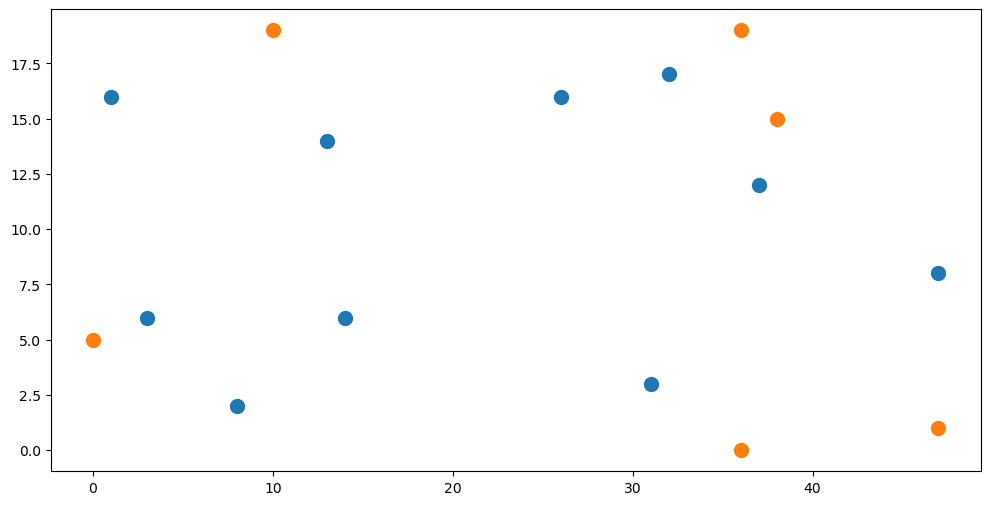

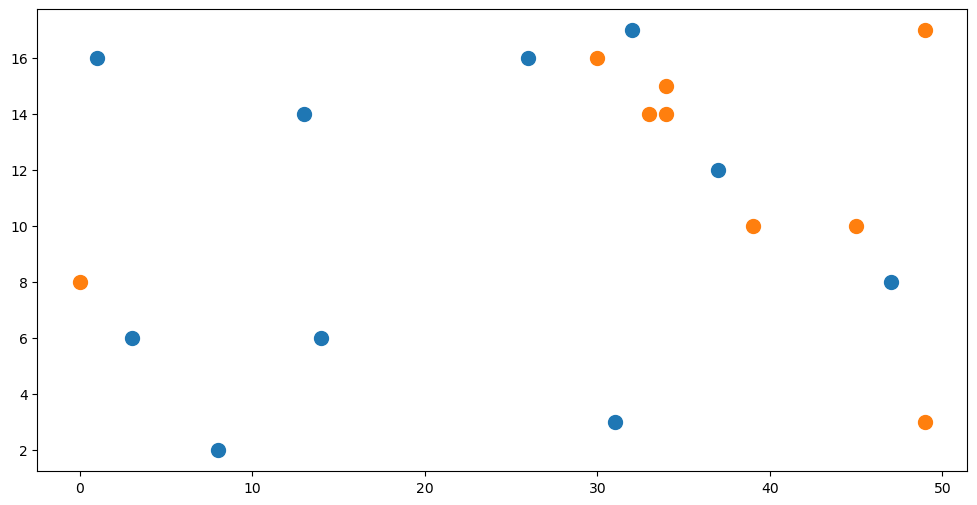

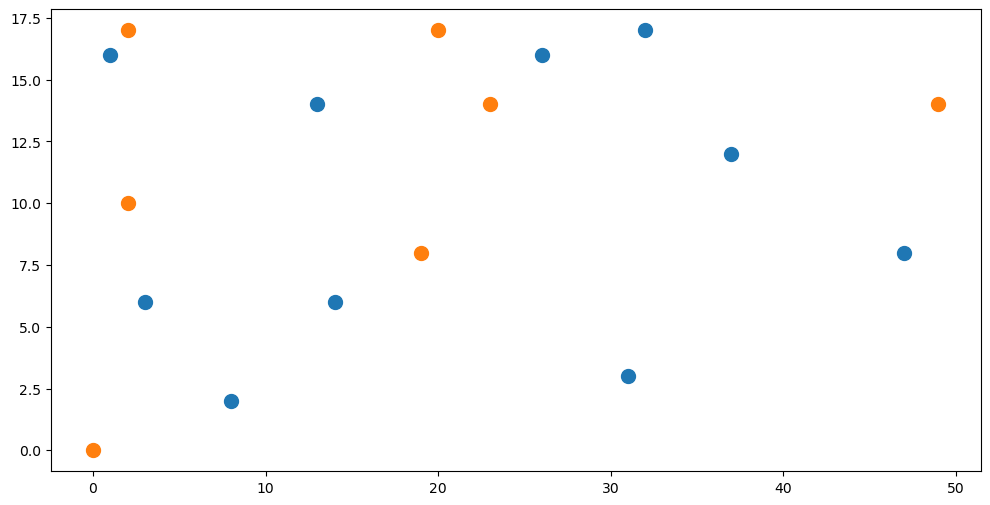

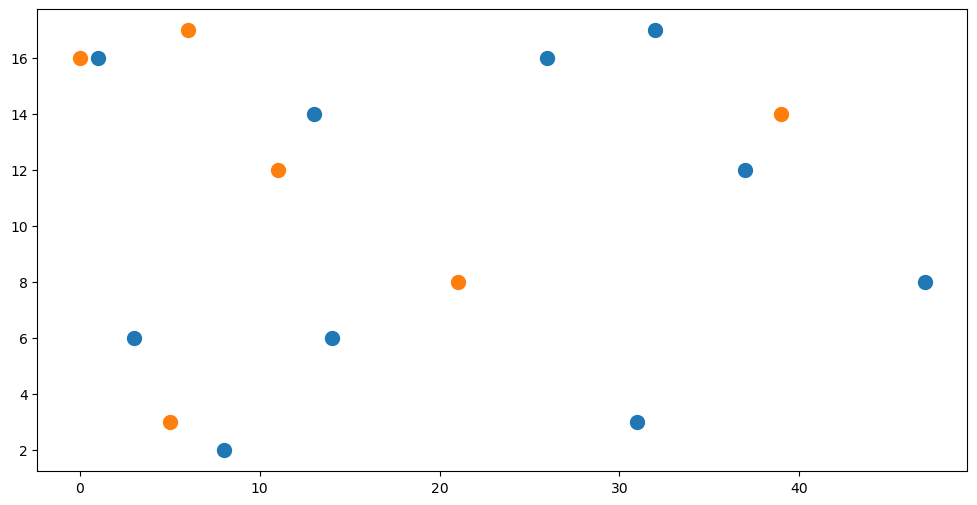

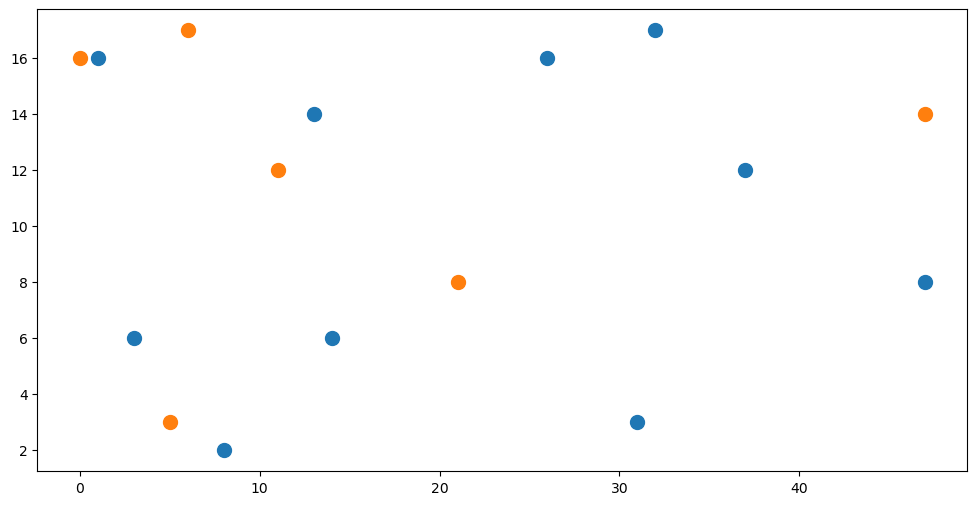

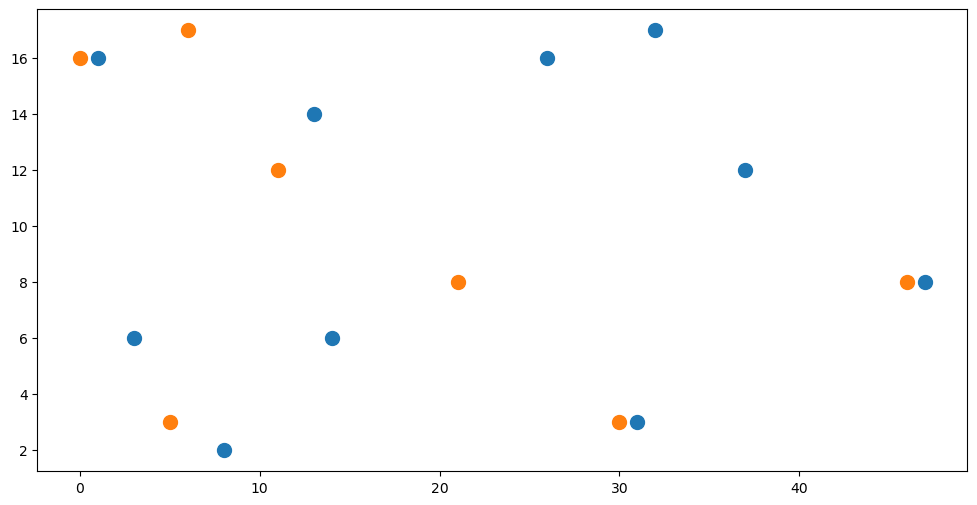

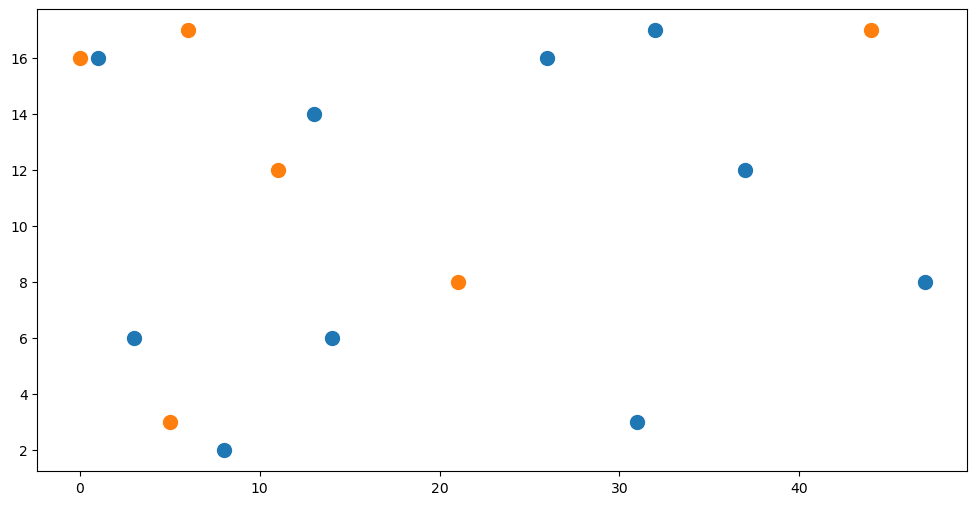

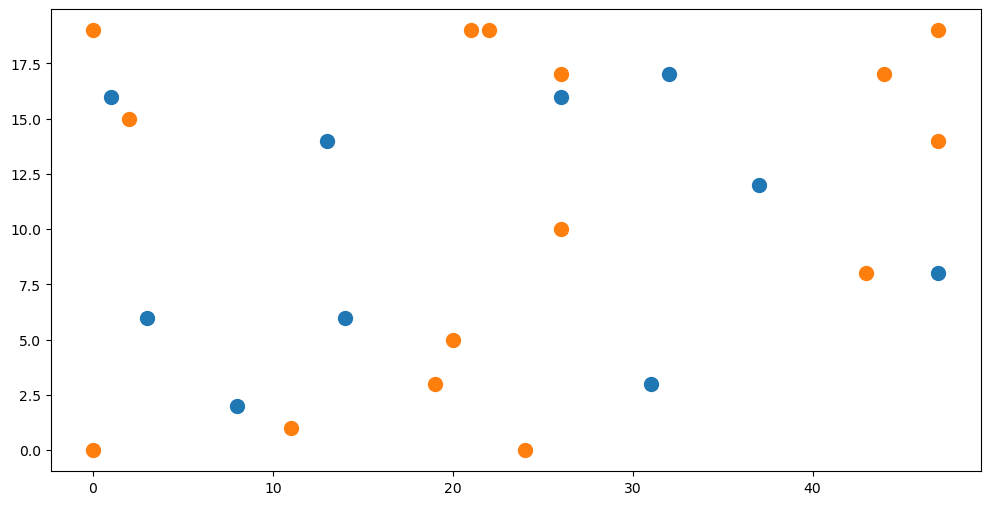

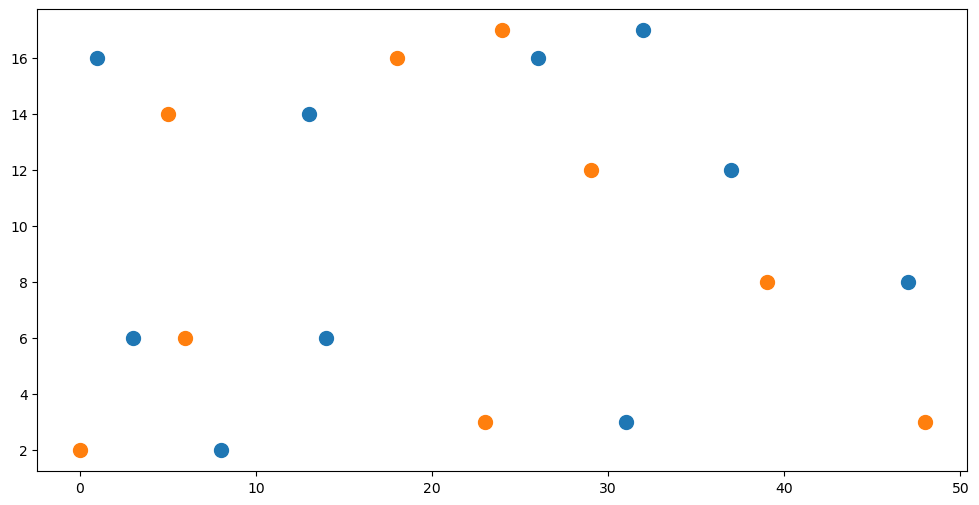

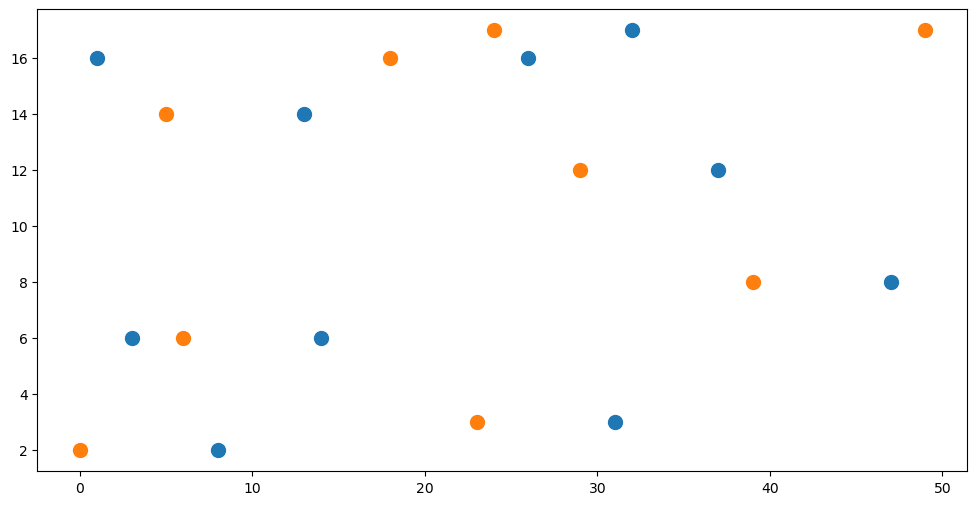

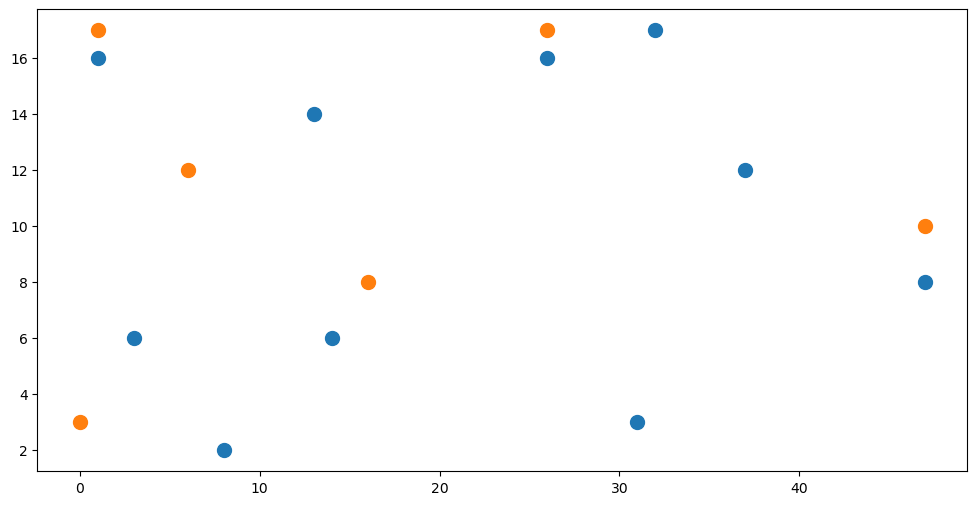

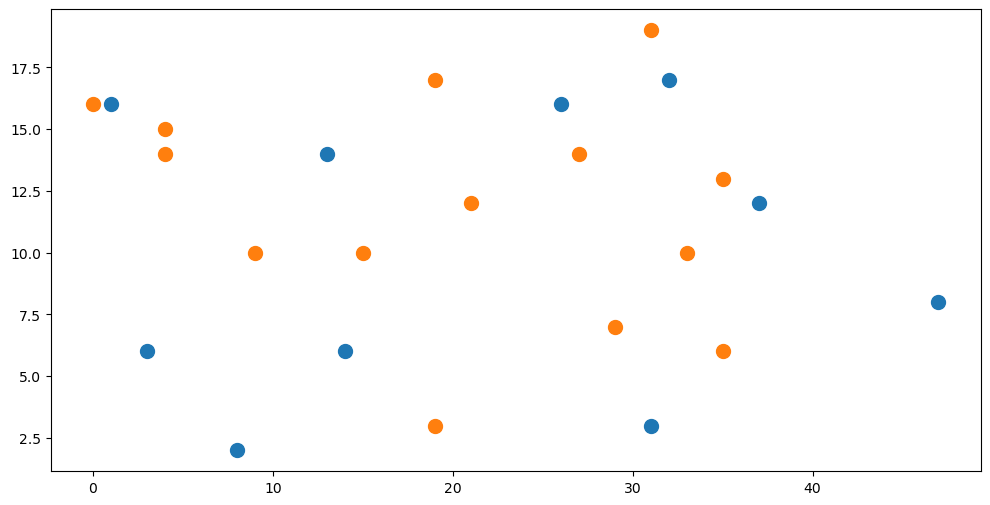

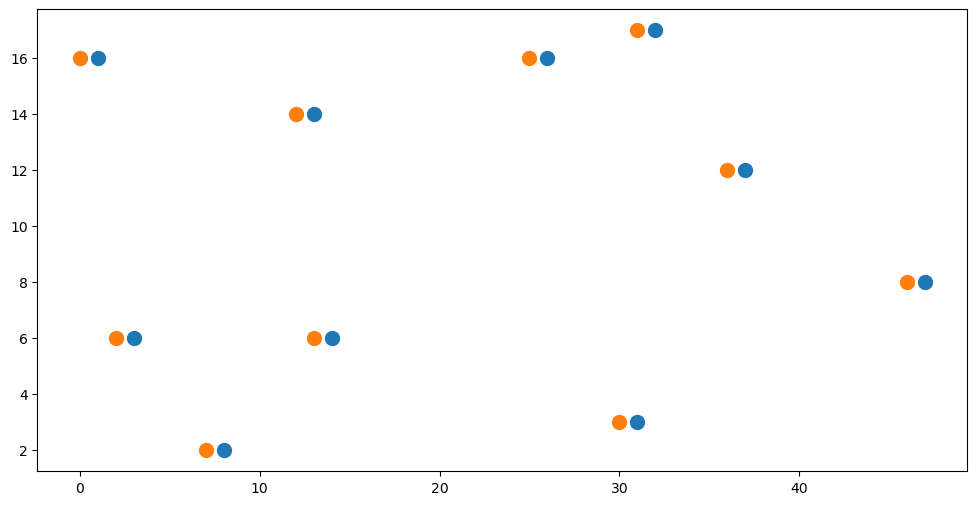

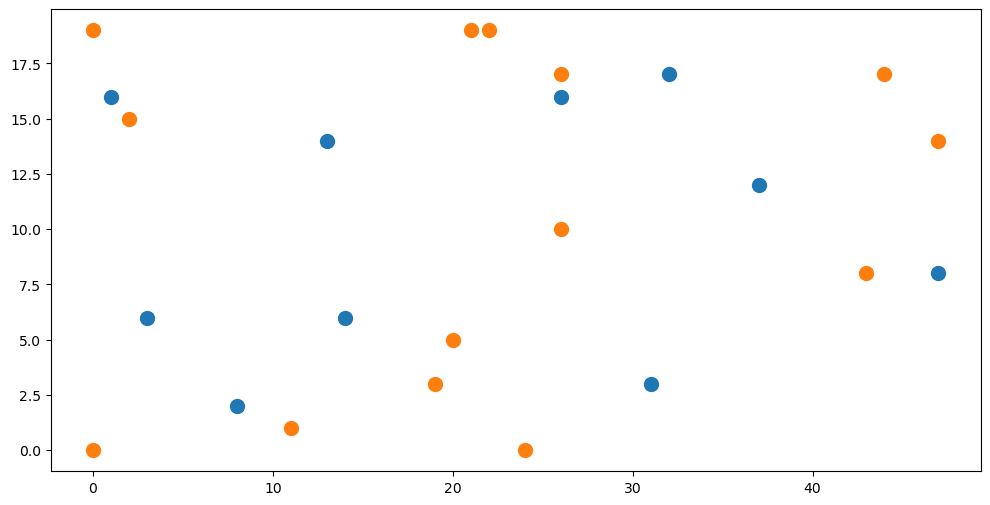

In [184]:
for pattern in spade_patterns_filt:
    plt.figure(figsize=(12,6))
    plt.scatter(K_sparse[1][K_sparse[2]==4],K_sparse[0][K_sparse[2]==4],s=100)
    plt.scatter(pattern.T[0],pattern.T[1],s=100)
    plt.show()

In [240]:
K_sparse[0]

array([ 0,  1,  4,  8,  9, 11, 13, 13, 14, 14], dtype=int64)

In [242]:
np.sort(np.array(pattern['neurons']))

array([ 0,  1,  4,  8,  9, 11, 13, 13, 14, 14], dtype=int32)

In [205]:
K_sparse[1]

array([ 2, 47, 46, 35, 28,  8, 14, 27, 25, 30], dtype=int64)

In [238]:
np.sort(np.array(pattern['itemset'])) % D

array([ 0, 45, 44, 33, 26,  6, 12, 25, 23, 28], dtype=int32)

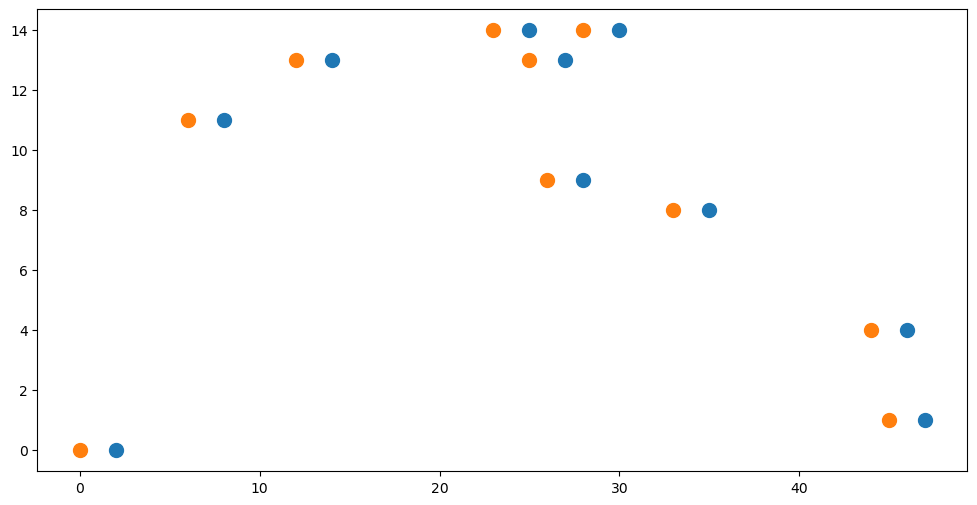

In [243]:

plt.figure(figsize=(12,6))
plt.scatter(K_sparse[1],K_sparse[0],s=100)
plt.scatter(np.sort(np.array(pattern['itemset'])) % D ,np.sort(np.array(pattern['neurons'])),s=100)
plt.show()

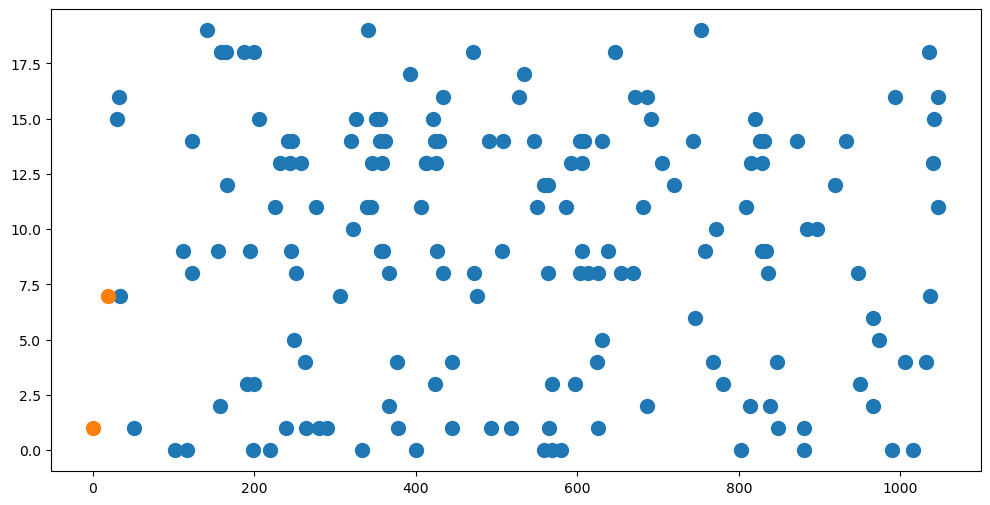

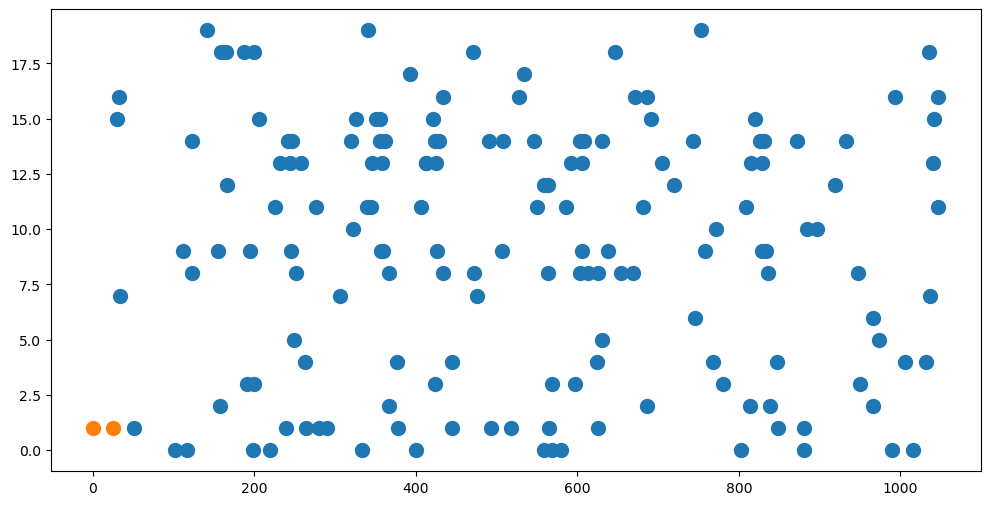

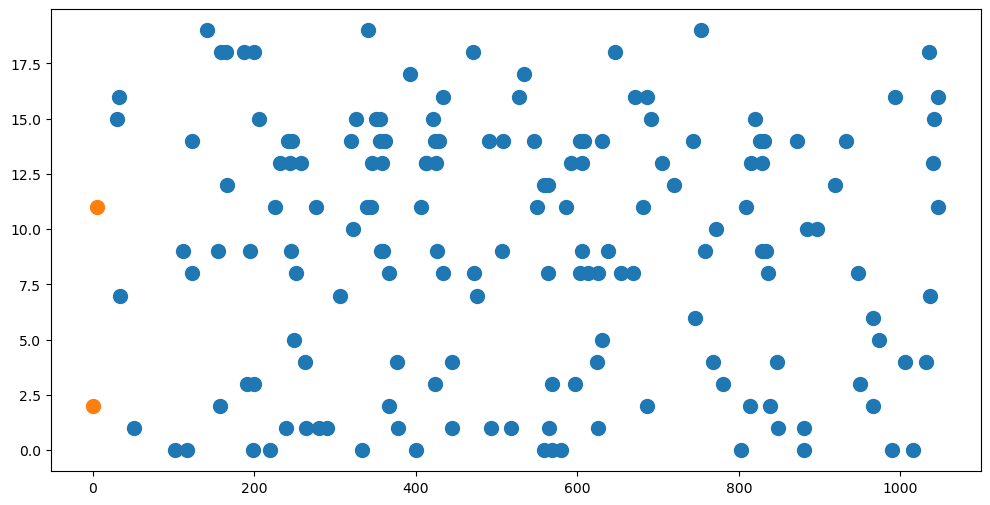

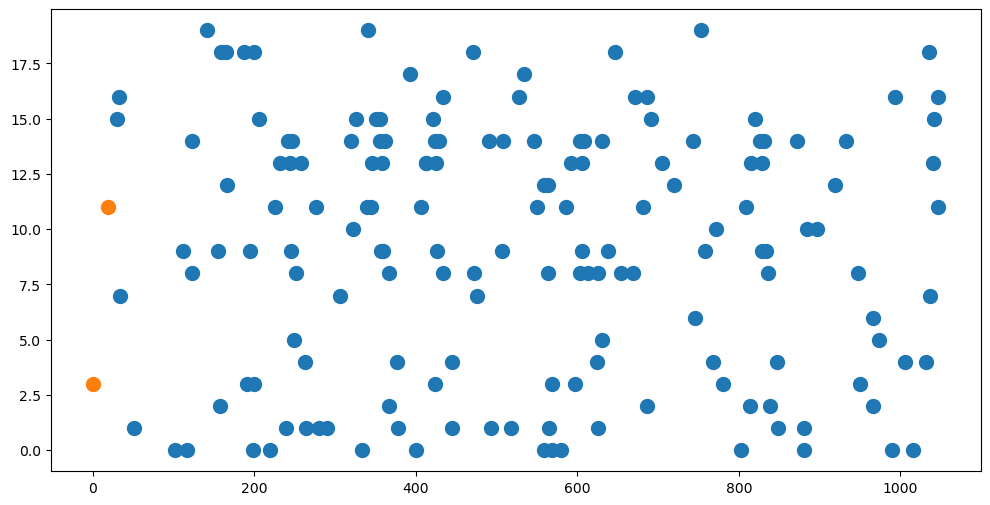

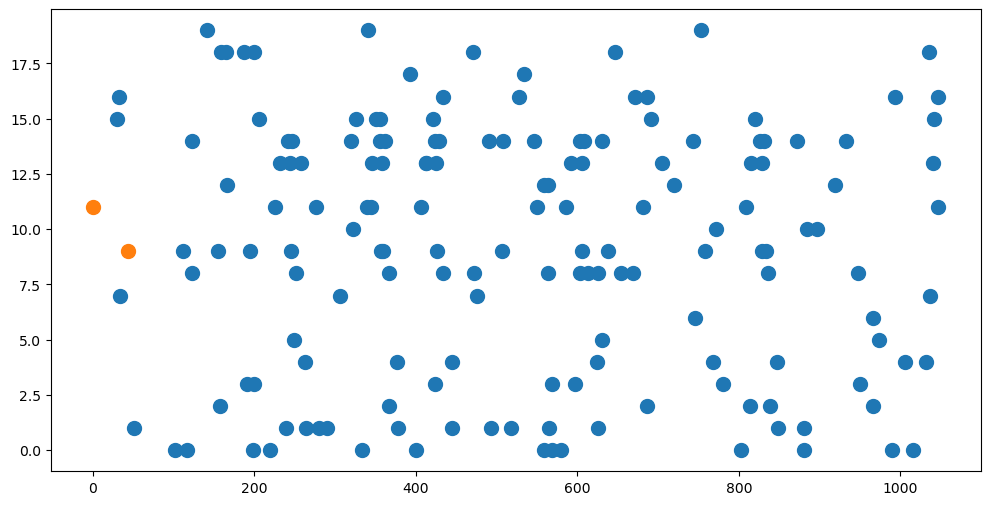

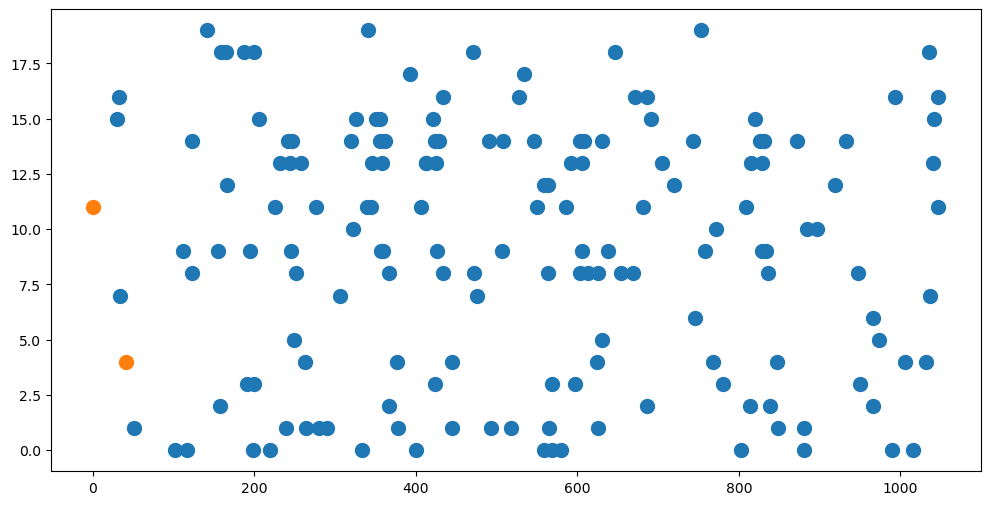

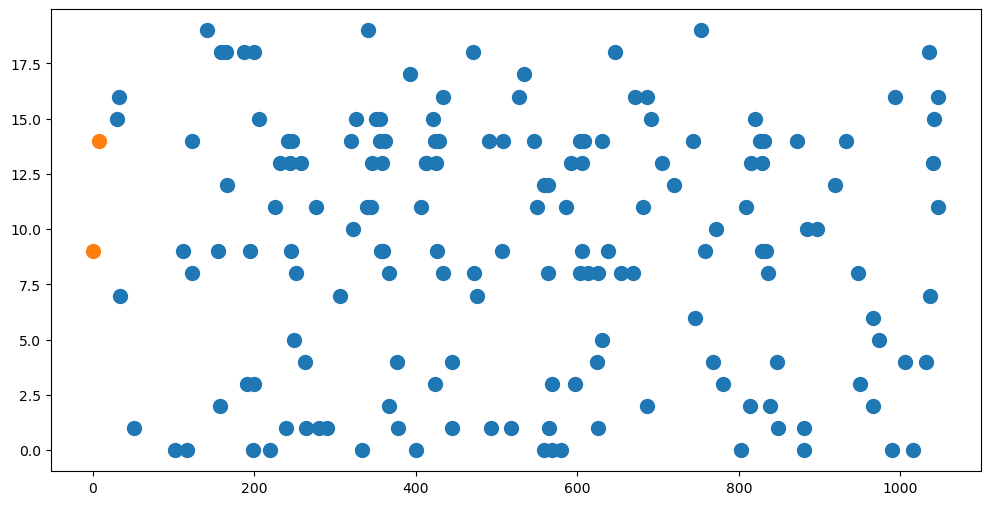

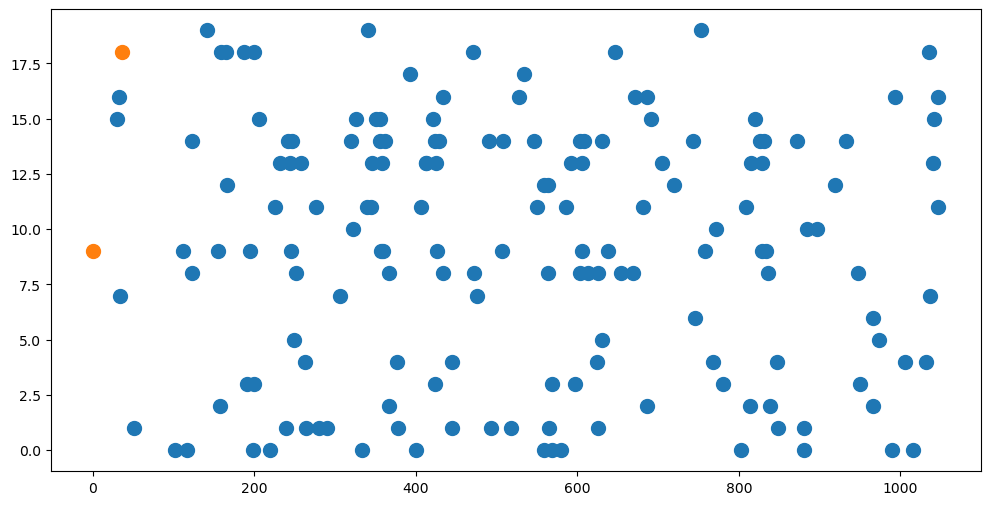

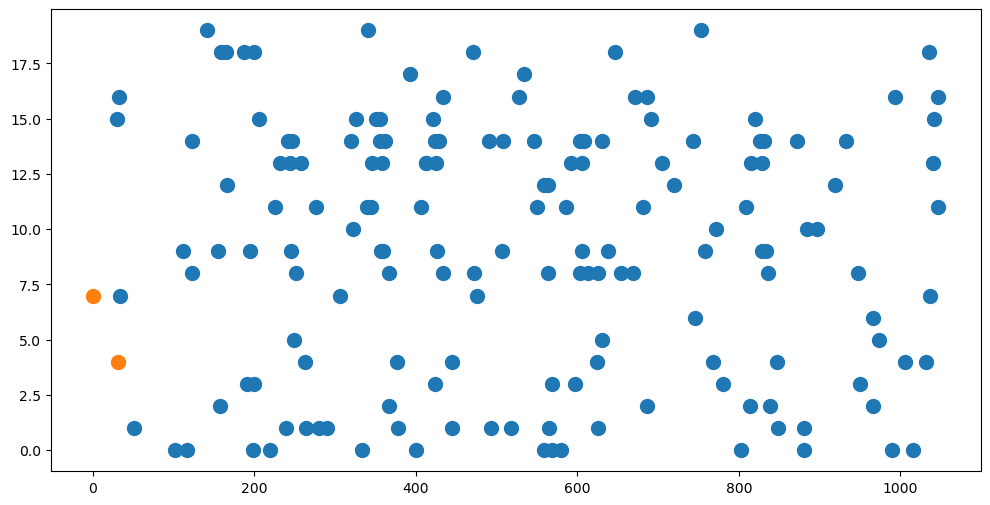

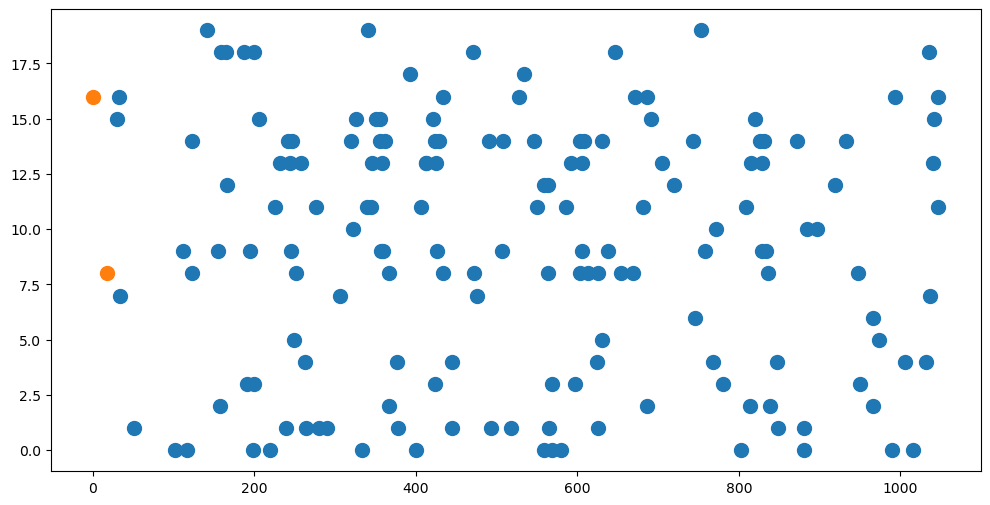

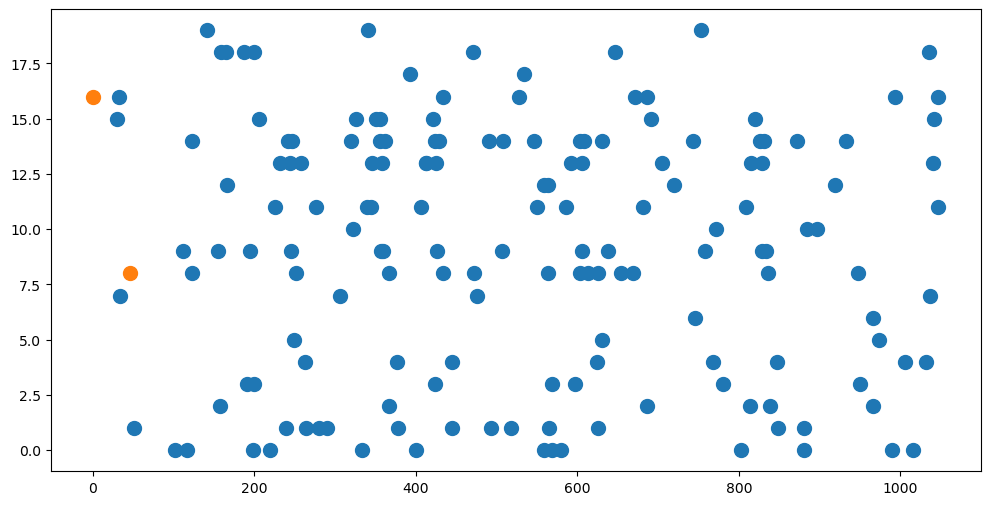

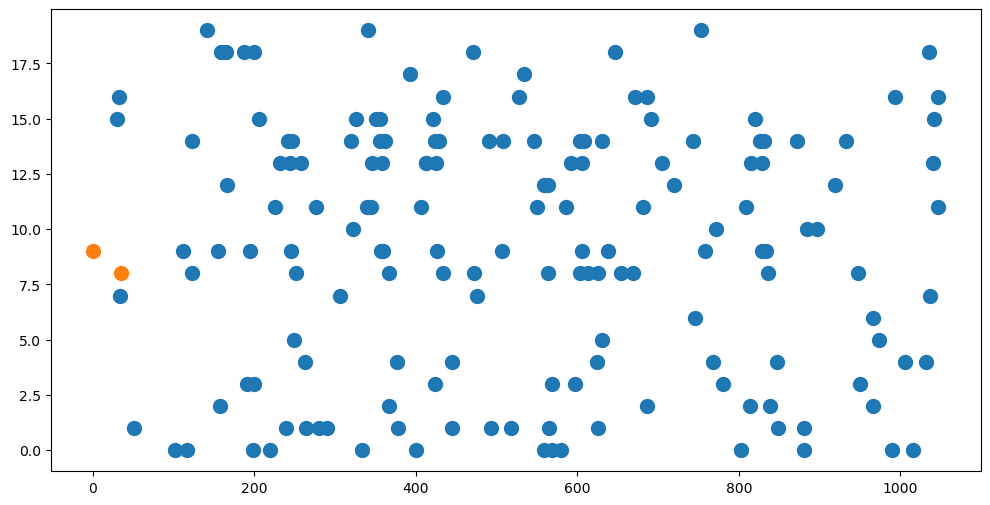

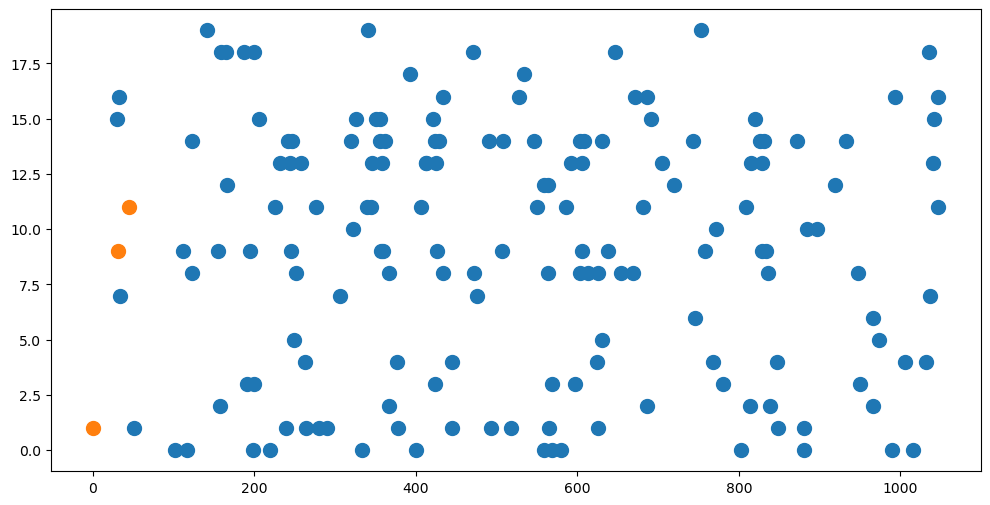

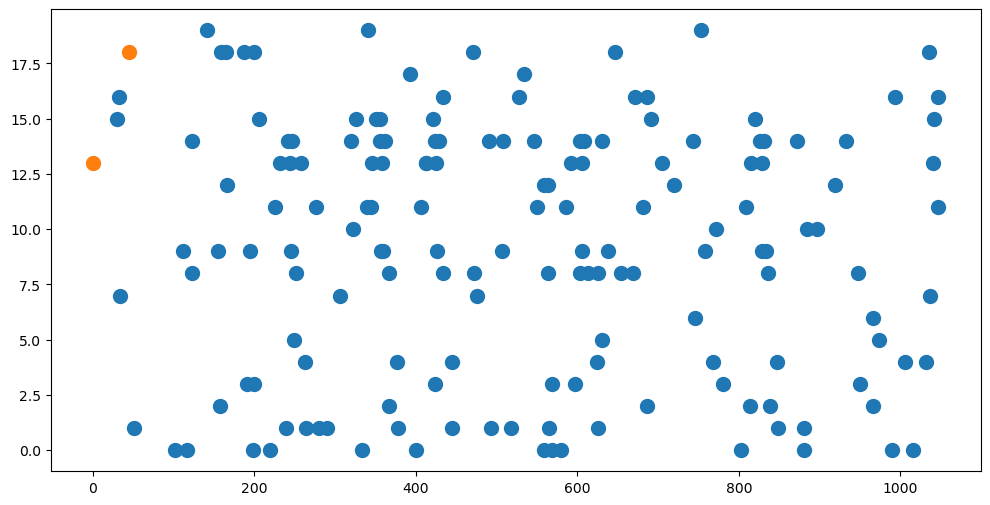

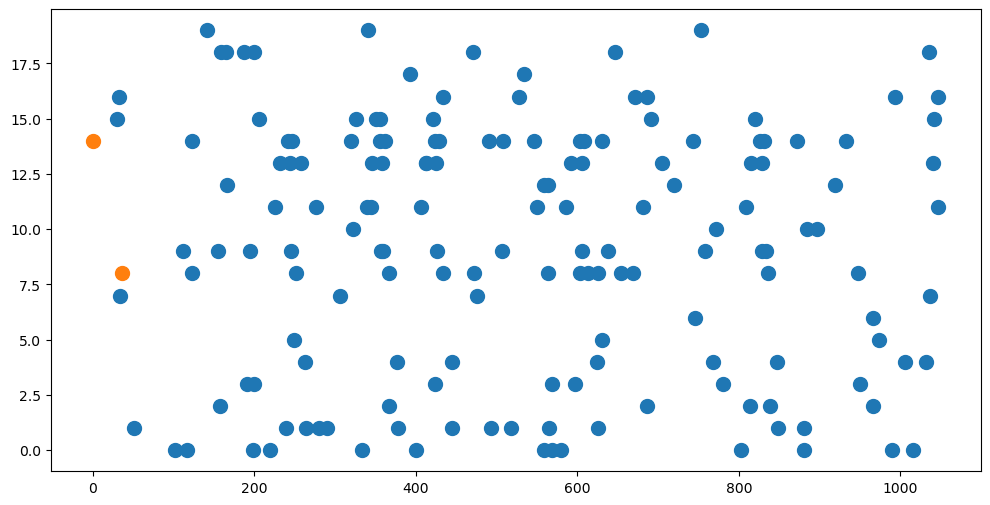

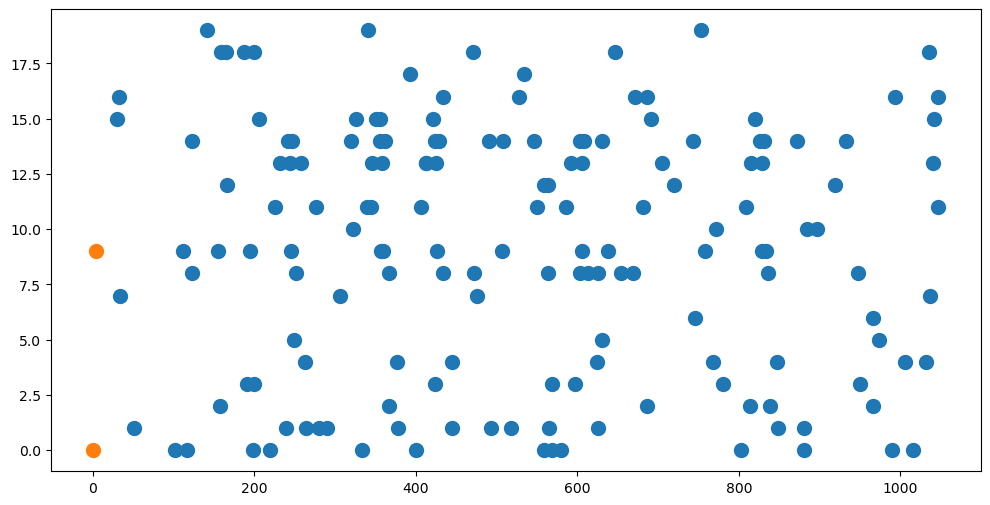

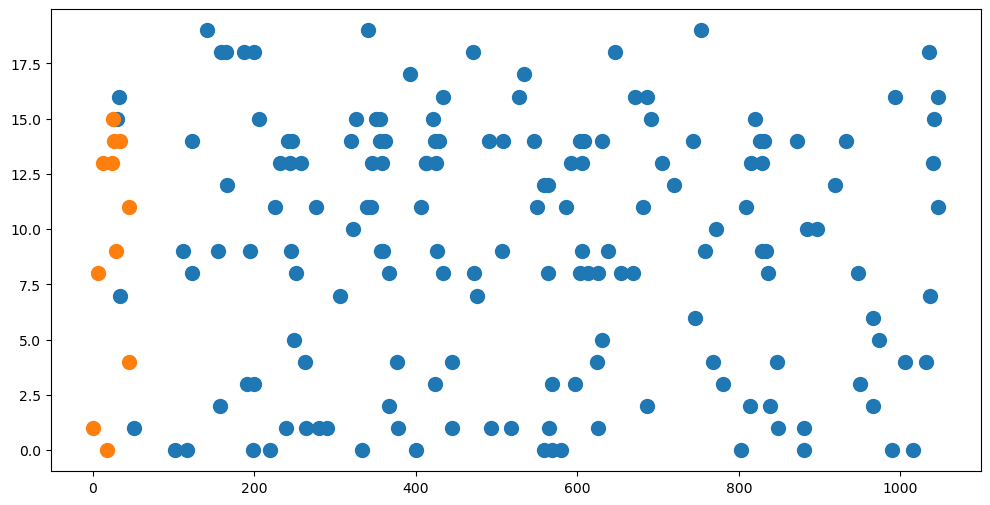

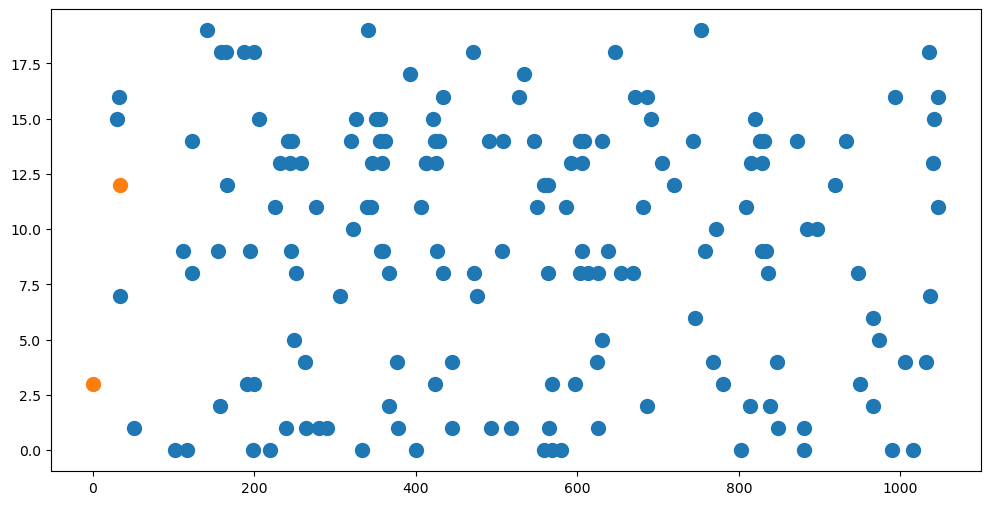

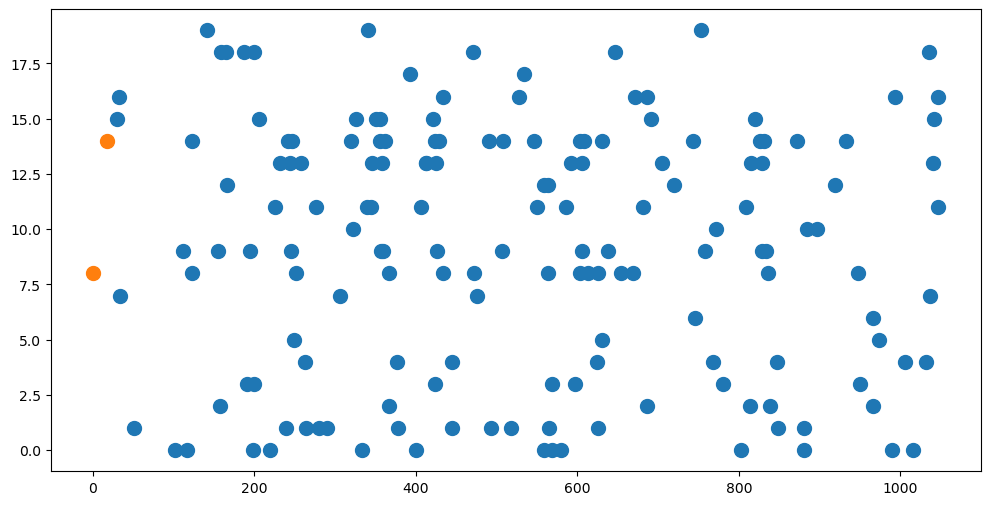

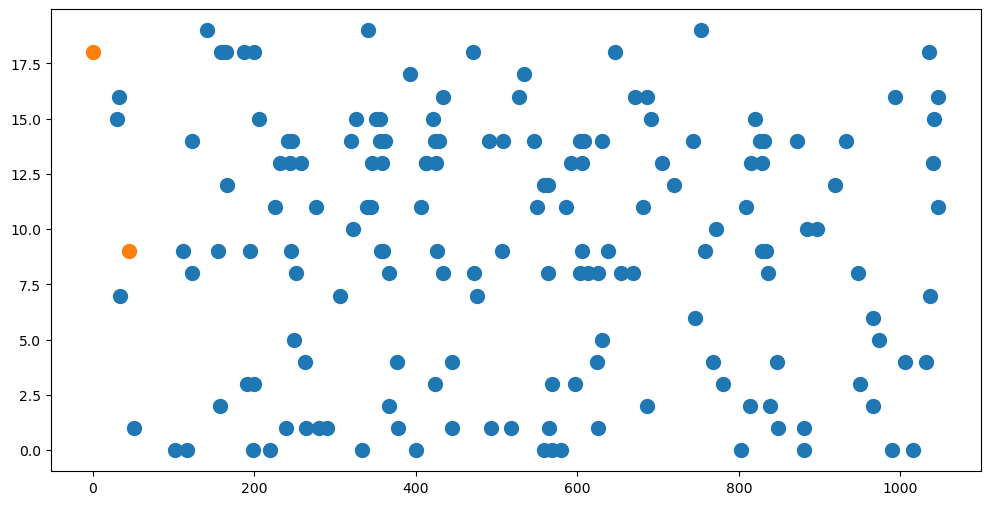

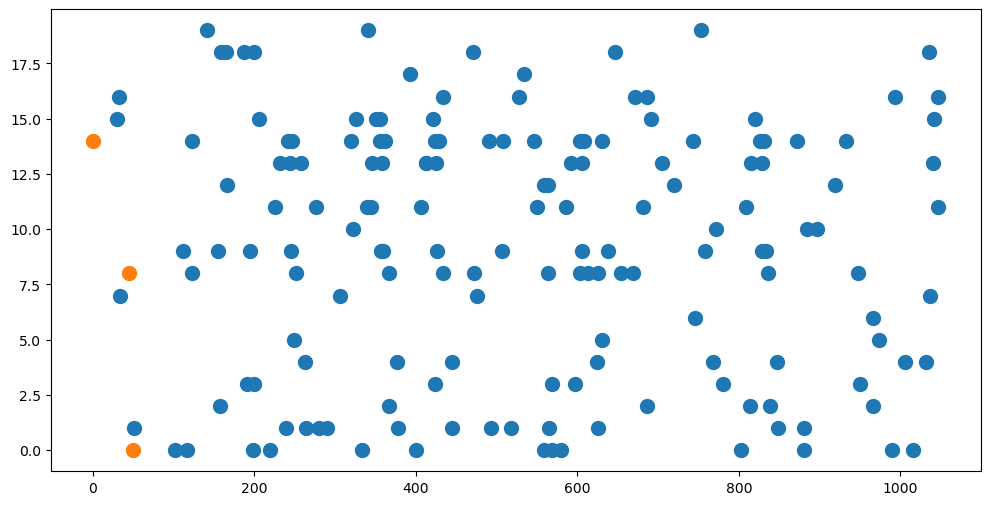

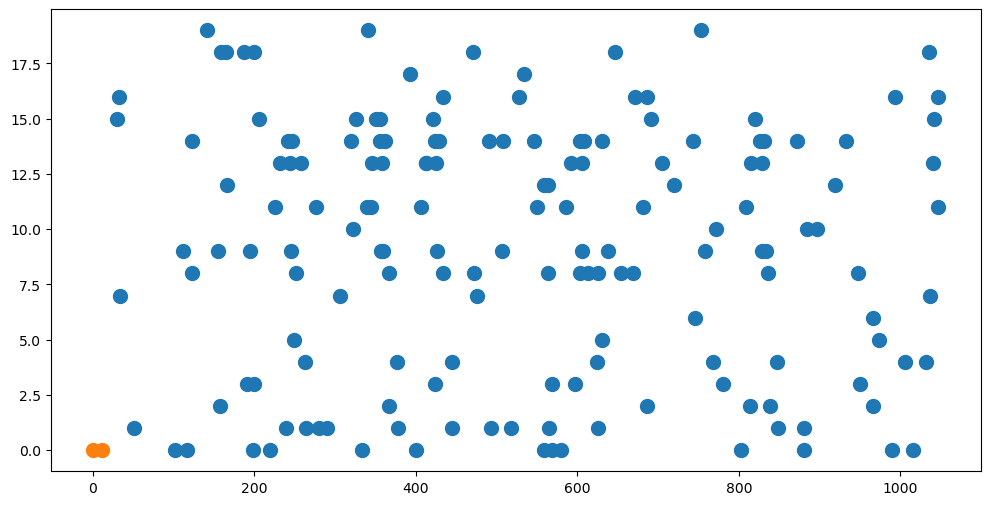

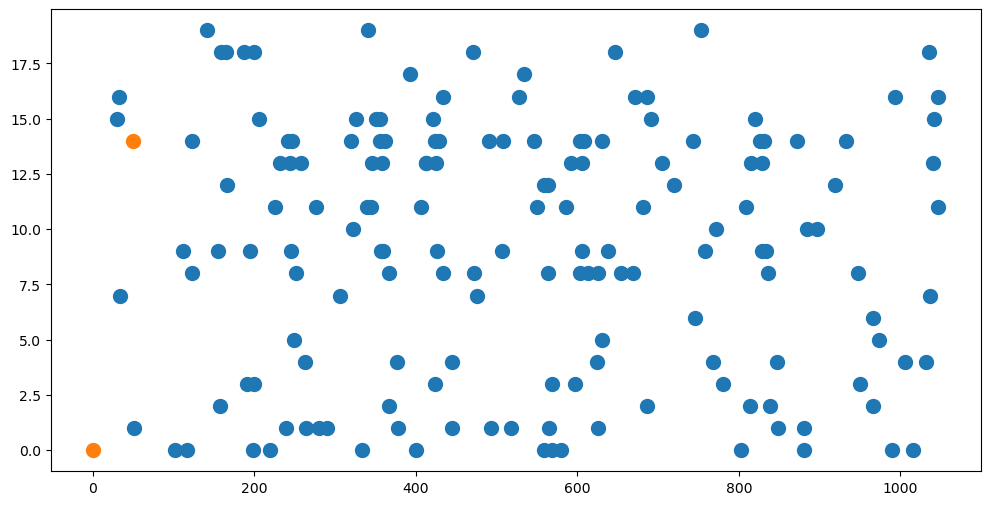

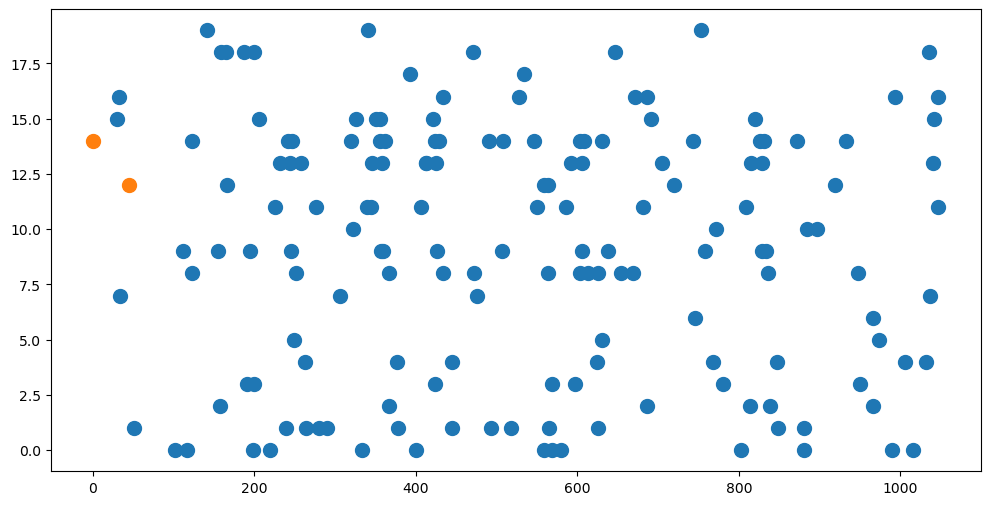

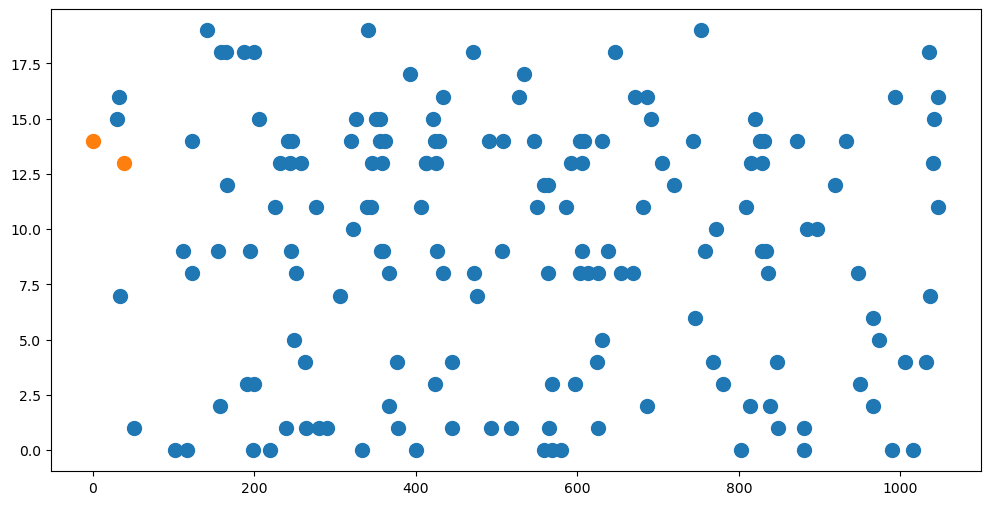

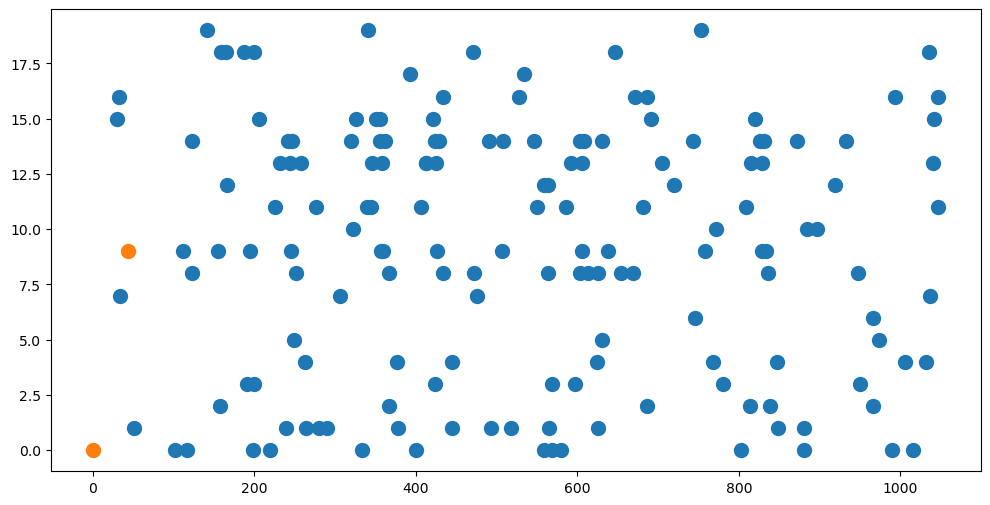

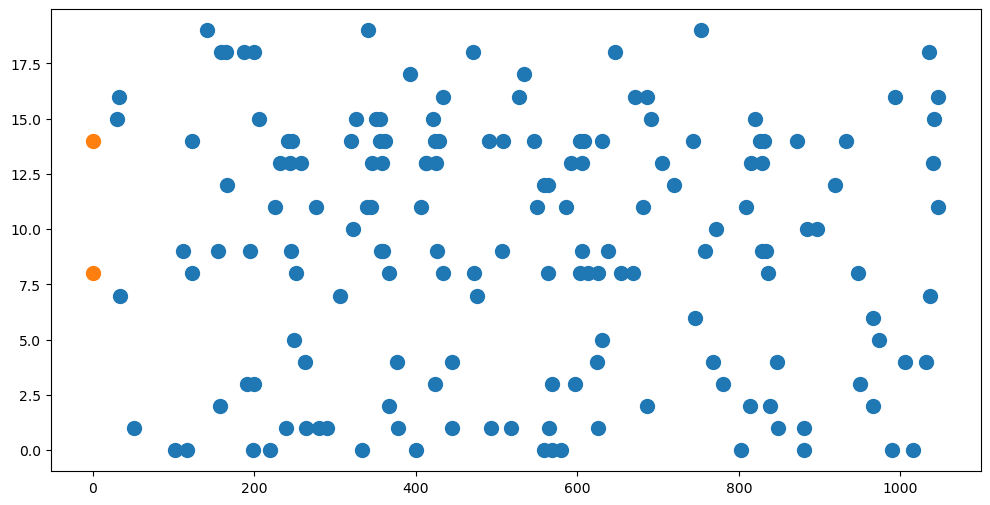

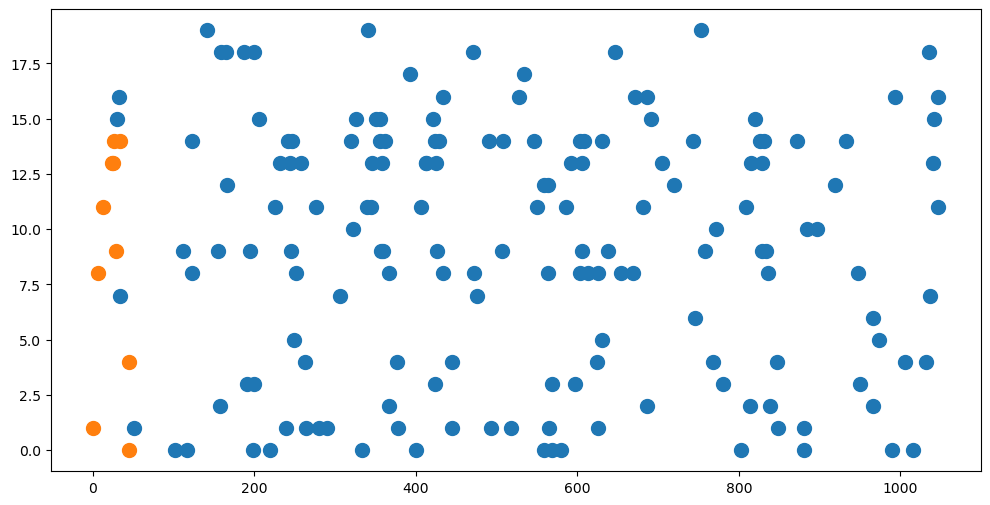

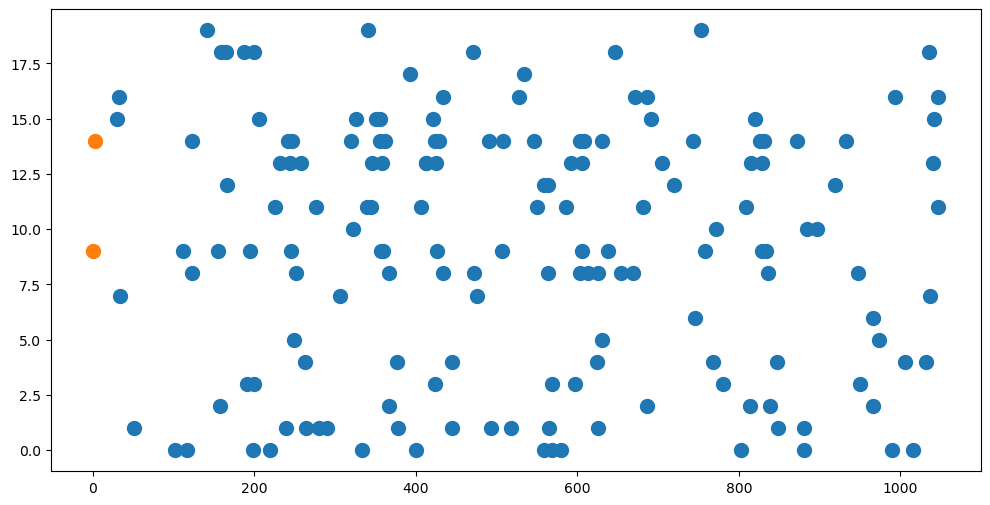

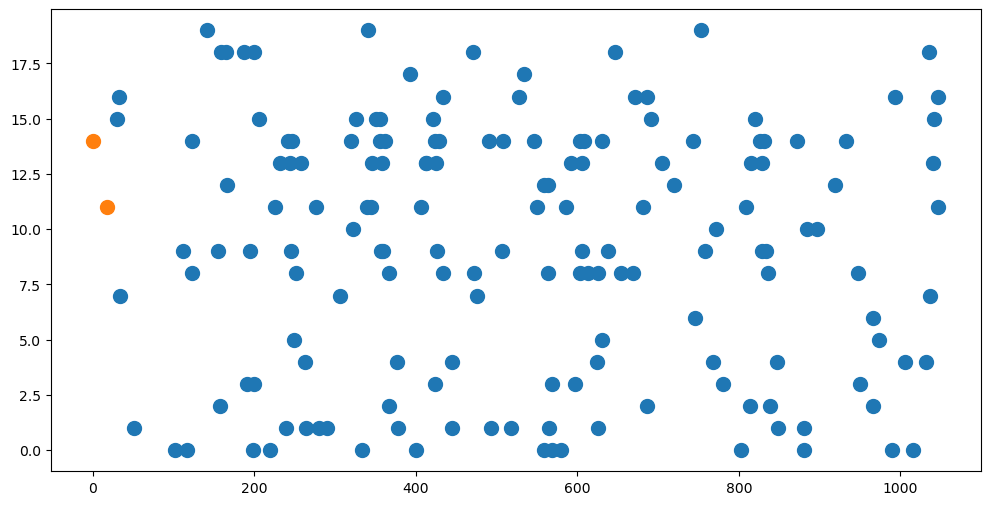

IndexError: list index out of range

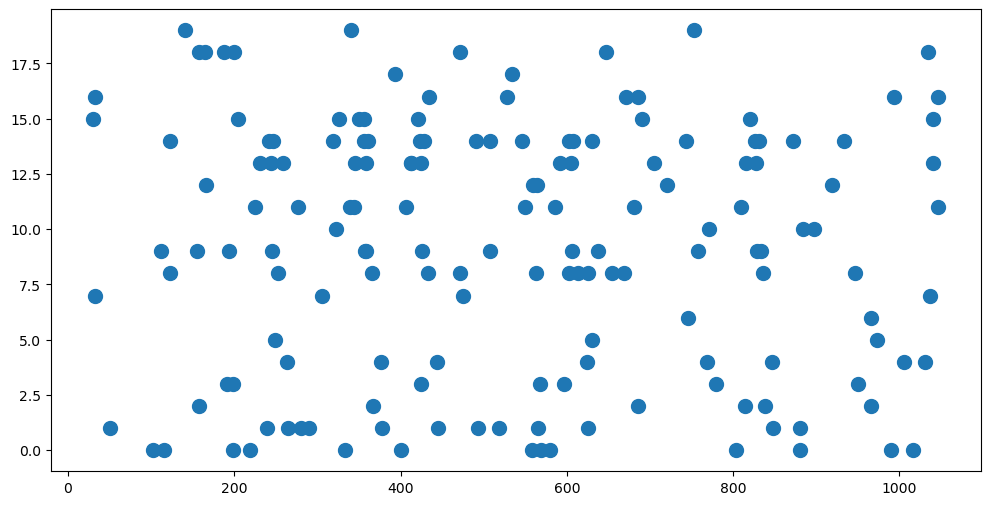

In [138]:
for i in range(50):
    plt.figure(figsize=(12,6))
    plt.scatter(A_sparse[1],A_sparse[0],s=100)
    plt.scatter(possible_patterns[i][0],possible_patterns[i][1],s=100)
    plt.show()